In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
#from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import scikitplot as skplt

In [2]:
# charts options
plt.figure(figsize=(15,5));
sns.set(rc={'figure.figsize':(15,5), 'xtick.direction':'in'});

# pandas options
pd.set_option('display.max_columns', 999)

<Figure size 1080x360 with 0 Axes>

In [3]:
"""
Carregando os dados, convertendo o nome dos times e quebrando em x,y
"""
def load_data(path, cols):
    df = pd.read_json(path)
    df = df.sort_index()
    
    df = teamNames2numbers(df)
    
    if cols!=None:
        df = df[cols]
    
    return df.drop('final_result', axis=1), df['final_result'] # x, y
    

"""
Convertendo o nome dos times para numeros

Vamos usar o LabelEncoder do sklearn pois existem centenas de times.
Essa transformação é necessária para que possamos fazer isso com novos dados.

O Random Forest acusou erro sem esse processamento.
"""

def teamNames2numbers(df):
    dft = df[['home_name', 'away_name']]
    le = preprocessing.LabelEncoder()

    name_trans = dft.apply(le.fit_transform)

    # para fazer a conversao inversa. Agora nao precisarei, mas depois sim.
    # name_trans.apply(le.inverse_transform)

    # substituindo os valores
    df.home_name = name_trans.home_name
    df.away_name = name_trans.away_name
    
    return df

In [4]:
cols = [
    'home_name', 'away_name', 
    #'home_score', 'away_score', 
    'final_result',
    #'time', 'round', 
    'home_pos', 'away_pos', 
    'home_last5all_home','away_last5all_away',
    'home_last5all_home_win', 'home_last5all_home_draw','home_last5all_home_lose', 
    'away_last5all_away_win', 'away_last5all_away_draw','away_last5all_away_lose', 
    'last5all_home_away_dif', 
    'fifa_home_ova','fifa_home_att', 'fifa_home_mid', 'fifa_home_def', 
    'fifa_away_ova','fifa_away_att', 'fifa_away_mid', 'fifa_away_def', 
    'elo_home_score','elo_away_score', 
    'tfm_value_home', 'tfm_value_away'
]

x, y = load_data('base-dados-clube-da-aposta.json', cols)

In [5]:
x.head(2)

,home_name,away_name,home_pos,away_pos,home_last5all_home,away_last5all_away,home_last5all_home_win,home_last5all_home_draw,home_last5all_home_lose,away_last5all_away_win,away_last5all_away_draw,away_last5all_away_lose,last5all_home_away_dif,fifa_home_ova,fifa_home_att,fifa_home_mid,fifa_home_def,fifa_away_ova,fifa_away_att,fifa_away_mid,fifa_away_def,elo_home_score,elo_away_score,tfm_value_home,tfm_value_away
0,87,157,1,11,9,-8,5,0,0,1,1,3,17,80,79,81,80,70,70,70,69,1813.906738,1392.986084,277980000.0,9450000.0
1,219,78,18,15,2,-7,2,3,0,1,1,3,9,70,70,71,69,67,69,67,67,1513.179932,1475.512939,10900000.0,9600000.0


In [6]:
y.head(2)

0    H
1    H
Name: final_result, dtype: object

## 1) Basemodel para comparação

Em um teste de começo de temporada um certo piloto piloto rodou logo nas primeiras curvas e perguntado o porque daquilo ele respondeu que precisava conhecer o limite do carro antes de querer andar mais rápido. Essa história é contada fielmente todo ano pelo nosso querido Galvão Bueno em suas transmissões de F1 :D.

Nós também precisamos saber o limite dos nossos dados e qual o modelo que melhor pode se encaixar nele. Vamos aplicar um algoritmo bastante simples e ver como ele se comporta. Depois tentamos aumentar a complexidade a fim de verificar se estamos estamos no caminho certo ou não.

### Decision tree

Talvez esse seja um dos algoritmos mais simples, eficaz e fácil de compreender que existem. Ele é um bom basemodel para começarmos:

C:\Users\Mark\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


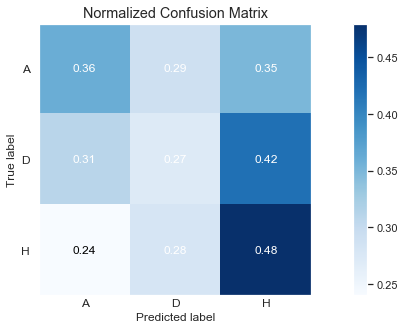

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=29384)

dt = DecisionTreeClassifier(random_state=0)
dt.fit(x_train, y_train)
skplt.metrics.plot_confusion_matrix(y_test, dt.predict(x_test), normalize=True)

In [8]:
print('Accuracy score: {0}'.format(accuracy_score(y_test, dt.predict(x_test))))

Accuracy score: 0.3905745642349903


Muito bem! Temos ~~nossa primeira saída na grama~~ o nosso basemodel e podemos tirar algumas informações bastante úteis.

O gráfico com os quadrados azuis chama-se `Matriz de confusão (Confusion matrix)` mas que de confuso não tem nada! Vou explicar: do lado esquerdo o `True label` são os nossos valores reais e a parte de baixo `Predicted label` são os valores que fizemos as predições. Do lado e em baixo também existem as letras `A D H` essas letras são nossos resultados dos jogos. Então, por exemplo, se tivermos o primeiro quadrado (0.36 - AxA) quer dizer que 35% das previsões foram feitas corretamente já que os valores originais foram previstos corretamente. Os quadrados do lado (0.3 e 0.36) indicam falsos positivos já que os dados originais seriam `A`, mas o modelo previu `D` ou `H`.

A linha de baixo está mais homogênea: apenas 27% dos dados foram previstos de forma correta. Se o modelo acertasse totalmente esse quadrado de 0.27 estaria em azul marinho. O modelo mostrou um viés errôneo para o time da casa também (0.42).

A última linha mostra que o modelo acertou quase metade das vezes quando o time da casa ganhou.

De forma geral: se o modelo tivesse acertado 100% dos resultados esse gráfico teria uma diagonal em azul descendo da esquerda para a direita. Então podemos dizer também que um bom modelo preditivo possui um gráfico que possui uma diagonal bastante aparente.

O `accuracy score` simplesmente conta a porcentagem de acertos que o modelo teve. Nosso modelo preditivo teve um score bem baixo: 39% apenas. Isso quer dizer que apenas em 39% das vezes ele acertou quem ia ganhar, perder ou empatar o jogo.

Agora que sabemos onde estamos pisando, podemos usar algumas estratégias para melhorar o desempenho.

In [9]:
"""
Essa função foi construída conforme o notebook foi sendo contruído. Sem ela as células ficariam muito grandes
e o objetivo principal de mostrar o resultado ficaria em segundo plano.
"""

def make_pred(x, y, model, test_prop=0.3, print_chart=True, use_smote=False, use_MinMax=False):
    cols = x.columns
    
    if use_smote:
        x, y = SMOTE().fit_resample(x, y)
        # x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_prop, random_state=29384)
    
    if use_MinMax:
        scaler = MinMaxScaler()
        x = pd.DataFrame(scaler.fit_transform(x), columns=cols)
        # x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_prop, random_state=29384)
        
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_prop, random_state=29384)
    
    model.fit(x_train, y_train)
    print('Accuraccy score: {0}'.format(accuracy_score(y_test, model.predict(x_test))))
    
    if hasattr(model, 'feature_importances_'): #verificando se metodo tem função. Apenas algoritmos ensemble tem esse metodo.
        result = view_feature_importances(cols, model.feature_importances_)
    
        if print_chart:
            result.plot(kind='barh')
            plt.show()
        
        return x, y, result
    
    return x, y, None

In [10]:
# Função que monta um dataframe para exibir as feature importances
def view_feature_importances(feat, impor):
    return pd.DataFrame({'features': feat, 'importances': impor}).sort_values(by='importances', ascending=False).set_index('features')

## 2) Feature selecting

Temos várias features no dataset e algumas delas podem ser apenas ruído, podendo ser removidas. Vamos usar o `Random Forest` para ver a importância de cada uma e verificar a accuracy do modelo com esse algoritmo mais elaborado.

O `Random Forest` é semelhante à Decision tree já que ele usa várias árvores de decisão (daí vem o nome :D) e com o resultado de todas elas, o algoritmo faz uma seleção dos melhores valores. É um algoritmo bastante poderoso mas tende a causar overfitting e por isso deve ser usado com certa calma.

Accuraccy score: 0.5067785668173015


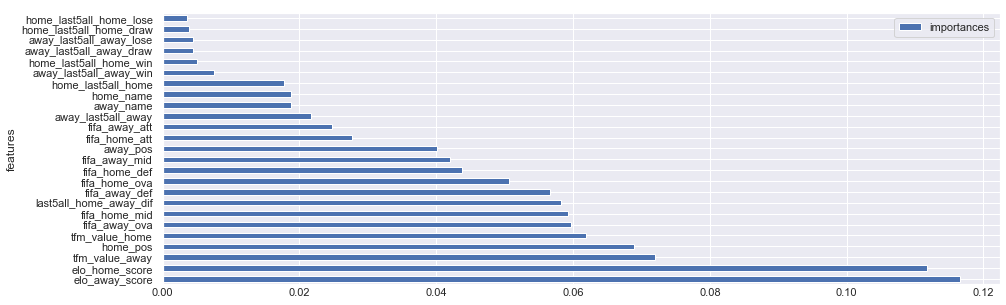

In [11]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=8, min_samples_leaf=50, random_state=99, verbose=0)
_ = make_pred(x, y, rf)

De cara percebemos que o `score elo` foi a feature mais importante para o modelo. A segunda feature mais importante foi a `tfm_value`. Ambas foram importantes para tanto para home quanto o away.

Se pensarmos bem isso faz bastante sentido, afinal um time com `score elo` alto vem mantendo bons resultados durante um tempo e um time que tem um `tfm_value` maior possui um elenco maior/melhor que o outro. Interessante foram as features do `FIFA` aparecerem em sua maior parte para os times away.

O `accuracy score` do modelo também aumentou: 50% das vezes o modelo acertou o resultado final. Bem melhor que os 39% anteriores, porém não satisfatório ainda.

Outro fato interessante foi o retrospecto aparecer bem abaixo na lista. Não fez muita diferença para o modelo saber sobre os últimos 5 jogos.

Como temos muitas features, podemos tentar juntar as `last5all` em uma única feature e verificar se ela tem um papel mais importante no modelo:

In [12]:
"""
Agrupando o retrospecto em uma única feature: aprov_5_home/away com a remoção dessas 3 em seguida.
"""

# Funções que calculam o aproveitamento do time nas últimas 5 partidas de acordo com
# os pontos que poderiam ser ganhos. O máximo é 15.
def aprov_last5_home(col):
    aprov_win = col['home_last5all_home_win']*3
    aprov_draw = col['home_last5all_home_draw']*1
    
    return int((aprov_win+aprov_draw)/15*100)

def aprov_last5_away(col):
    aprov_win = col['away_last5all_away_win']*3
    aprov_draw = col['away_last5all_away_draw']*1
    
    return int((aprov_win+aprov_draw)/15*100)

# Aplicando a função para o dataset inteiro
x['aprov_5_home'] = x[['home_last5all_home_win', 'home_last5all_home_draw']].apply(lambda x: aprov_last5_home(x), axis=1)
x['aprov_5_away'] = x[['away_last5all_away_win', 'away_last5all_away_draw']].apply(lambda x: aprov_last5_away(x), axis=1)


# Removendo as 3 features
x.drop(['home_last5all_home_win', 'home_last5all_home_draw', 'home_last5all_home_lose',
         'away_last5all_away_win', 'away_last5all_away_draw', 'away_last5all_away_lose'], axis=1, inplace=True)

Accuraccy score: 0.5029051000645578


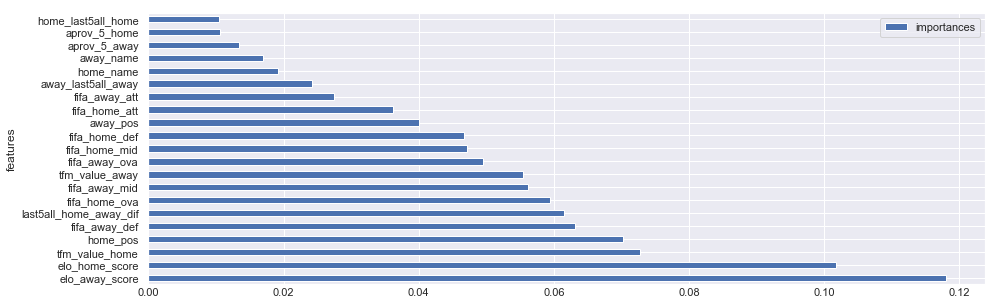

In [13]:
_ = make_pred(x, y, rf)

Mesmo juntando criando a feature de retrospecto e removendo as que criaram esta, o modelo não se importou muito com ela. Outra feature que foi pouco decisiva foi o saldo de gols nas 5 últimas `away/home_last5all_home`. Saber quem jogou `away/home_name` também não causou grande impacto. Vamos removê-las:

Accuraccy score: 0.5061329890251776


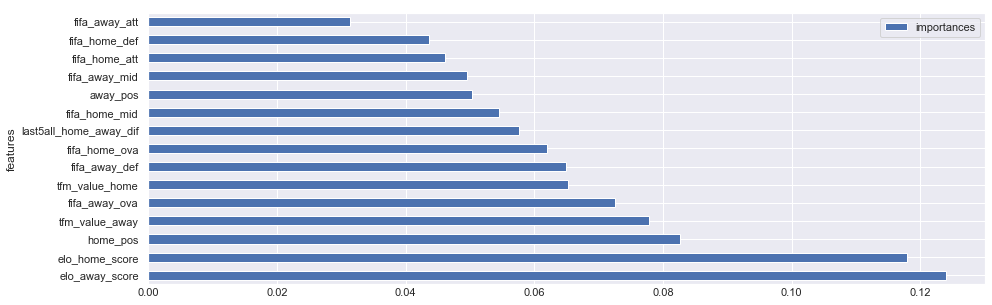

In [14]:
cols = [
    #'home_name', 'away_name', 
    #'home_score', 'away_score', 
    'final_result',
    #'time', 'round', 
    'home_pos', 'away_pos', 
    #'home_last5all_home','away_last5all_away',
    #'home_last5all_home_win', 'home_last5all_home_draw','home_last5all_home_lose', 
    #'away_last5all_away_win', 'away_last5all_away_draw','away_last5all_away_lose', 
    'last5all_home_away_dif', 
    'fifa_home_ova','fifa_home_att', 'fifa_home_mid', 'fifa_home_def', 
    'fifa_away_ova','fifa_away_att', 'fifa_away_mid', 'fifa_away_def', 
    'elo_home_score','elo_away_score', 
    'tfm_value_home', 'tfm_value_away'
]

x, y = load_data('base-dados-clube-da-aposta.json', cols)
result = make_pred(x, y, rf) # a função retorna um dataframe

Reduzimos para 15 features sem prejudicar o modelo e isso ajuda a evitar overfitting. Como não sabemos a quantidade de features ideal, vamos deixar as 15 melhores e tentar outras técnicas.

## 2) Desbalanceamento

In [15]:
y.value_counts(normalize=True) # valores em porcentagem

H    0.446640
A    0.290529
D    0.262832
Name: final_result, dtype: float64

O dataset está um pouco desbalanceado e isso talvez possa influenciar o modelo a ter um viés maior para os donos da casa. Podemos criar dados falsos com a técnica de `SMOTE` para tirar essa dúvida:

> Implementação do SMOTE já adicionada na função `make_pred()`. O uso aqui possui apenas o set do parâmetro `use_smote=True`.

Accuraccy score: 0.476878612716763


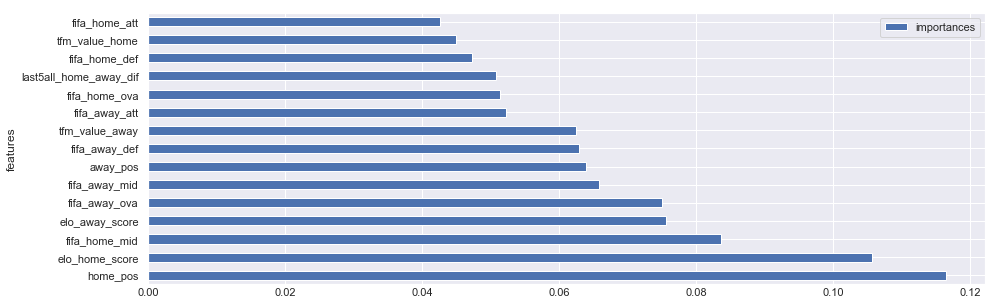

In [16]:
cols = [
    #'home_name', 'away_name', 
    #'home_score', 'away_score', 
    'final_result',
    #'time', 'round', 
    'home_pos', 'away_pos', 
    #'home_last5all_home','away_last5all_away',
    #'home_last5all_home_win', 'home_last5all_home_draw','home_last5all_home_lose', 
    #'away_last5all_away_win', 'away_last5all_away_draw','away_last5all_away_lose', 
    'last5all_home_away_dif', 
    'fifa_home_ova','fifa_home_att', 'fifa_home_mid', 'fifa_home_def', 
    'fifa_away_ova','fifa_away_att', 'fifa_away_mid', 'fifa_away_def', 
    'elo_home_score','elo_away_score', 
    'tfm_value_home', 'tfm_value_away'
]

x, y = load_data('base-dados-clube-da-aposta.json', cols)

x_smote, y_smote, _ = make_pred(x, y, rf, use_smote=True)

In [17]:
# A função retorna os dados oversampled.
pd.Series(y_smote).value_counts(normalize=True)

A    0.333333
H    0.333333
D    0.333333
dtype: float64

Mesmo fazendo o oversampling dos dados, não houve melhora do modelo. Podemos tentar outra técnica.

## 3) Normalização

Os dados estão com escalas diferentes entre as colunas. Isso não faz muita diferença para o `Random Forest` mas já que estamos tentando melhorar o modelo, podemo usar isso também. Isso será útil para o próximo passo pois tentaremos outros algoritmos.

Existem várias formas de colocar os dados em uma única escala. Aqui vamos nos concentrar na mais usada: `MinMax Scaler`. Essa escala não necessita que os dados estejam em uma curva normal e deixará os dados com valor entre 0 e 1:

C:\Users\Mark\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Accuraccy score: 0.5061329890251776


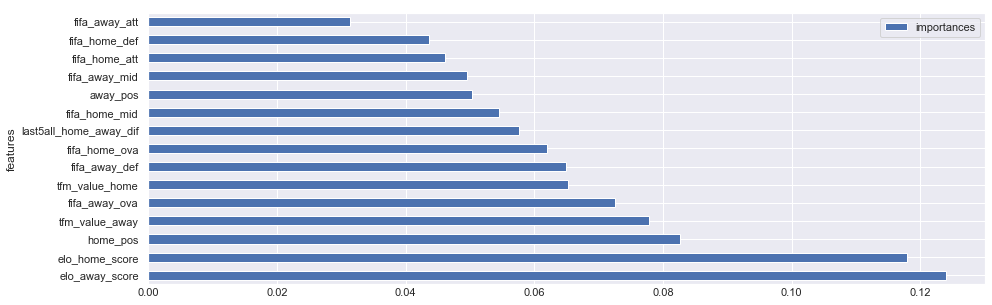

In [18]:
cols = [
    #'home_name', 'away_name', 
    #'home_score', 'away_score', 
    'final_result',
    #'time', 'round', 
    'home_pos', 'away_pos', 
    #'home_last5all_home','away_last5all_away',
    #'home_last5all_home_win', 'home_last5all_home_draw','home_last5all_home_lose', 
    #'away_last5all_away_win', 'away_last5all_away_draw','away_last5all_away_lose', 
    'last5all_home_away_dif', 
    'fifa_home_ova','fifa_home_att', 'fifa_home_mid', 'fifa_home_def', 
    'fifa_away_ova','fifa_away_att', 'fifa_away_mid', 'fifa_away_def', 
    'elo_home_score','elo_away_score', 
    'tfm_value_home', 'tfm_value_away'
]

x, y = load_data('base-dados-clube-da-aposta.json', cols)

x_scaled, y, _ = make_pred(x, y, rf, use_MinMax=True)

In [19]:
x_scaled.head(4)

,home_pos,away_pos,last5all_home_away_dif,fifa_home_ova,fifa_home_att,fifa_home_mid,fifa_home_def,fifa_away_ova,fifa_away_att,fifa_away_mid,fifa_away_def,elo_home_score,elo_away_score,tfm_value_home,tfm_value_away
0,0.000000,0.434783,0.771930,0.739130,0.59375,0.730769,0.740741,0.304348,0.31250,0.28,0.333333,0.702350,0.181887,0.252800,0.005054
1,0.739130,0.608696,0.631579,0.304348,0.31250,0.346154,0.333333,0.173913,0.28125,0.16,0.259259,0.326929,0.285490,0.007039,0.005176
2,0.260870,0.043478,0.438596,0.086957,0.31250,0.115385,0.185185,0.217391,0.25000,0.20,0.333333,0.166773,0.311003,0.003175,0.010271
3,0.043478,0.217391,0.684211,0.826087,0.75000,0.807692,0.777778,0.869565,0.75000,0.76,0.703704,0.848410,0.744781,0.837129,0.678011


Também não houve melhora no modelo :(

## 4) Outros algoritmos

Tentamos algumas técnicas mas o resultado não foi totalmente positivo. Podemos tentar usar outros algoritmos de classificação e verificar se teremos resultados melhores. Vamos utilizar o `GridSearchCV` para testar algumas combinações de hyperparametros aproveitando os dados de uma maneira melhor usando o cross-validation.

In [20]:
cols = [
    #'home_name', 'away_name', 
    #'home_score', 'away_score', 
    'final_result',
    #'time', 'round', 
    'home_pos', 'away_pos', 
    #'home_last5all_home','away_last5all_away',
    #'home_last5all_home_win', 'home_last5all_home_draw','home_last5all_home_lose', 
    #'away_last5all_away_win', 'away_last5all_away_draw','away_last5all_away_lose', 
    'last5all_home_away_dif', 
    'fifa_home_ova','fifa_home_att', 'fifa_home_mid', 'fifa_home_def', 
    'fifa_away_ova','fifa_away_att', 'fifa_away_mid', 'fifa_away_def', 
    'elo_home_score','elo_away_score', 
    'tfm_value_home', 'tfm_value_away'
]

x, y = load_data('base-dados-clube-da-aposta.json', cols)

In [21]:
# Usando Logistic Regression
logit = LogisticRegression(random_state=78, multi_class='multinomial', solver='lbfgs')

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
gscv = GridSearchCV(logit, param_grid, scoring='accuracy', n_jobs=-1, cv=6)
gscv.fit(x, y)
gscv.best_score_

0.5041642455936471

In [22]:
# demora muito. Abandonado

# %%time
# # Usando LinearSVC. Esse algoritmo costuma demorar muito...
# 
# svc = LinearSVC(random_state=78, max_iter=2000)
# 
# param_grid = {'multi_class': ['ovr', 'crammer_singer'], 'dual': [True, False] }
# gscv = GridSearchCV(svc, param_grid, scoring='accuracy', n_jobs=-1, cv=None)
# gscv.fit(x, y)
# gscv.best_score_
# 

In [38]:
%%time
# Usando Naives Bayes. Esse algoritmo é bastante simples e as vezes acaba surpreendendo pelo seu desempenho e simplicidade.

nbm = MultinomialNB()
xnorm = MinMaxScaler().fit_transform(x)

param_grid = {'alpha': [0, 0.5, 1], 'fit_prior': [True, False] }
gscv = GridSearchCV(nbm, param_grid, scoring='accuracy', n_jobs=-1, cv=6)
gscv.fit(xnorm, y)
print(gscv.best_score_)

C:\Users\Mark\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


0.48285880302149914
Wall time: 604 ms


## 4) XGBoost

O XGBoost é um dos algoritmos mais usados atualmente para fazer predições. Várias competições no Kaggle são vencidas usando esse algoritmo. Ele aceita implementações em formato próprio e usando sklearn. Vamos utilizar o formato próprio para usarmos todos os recursos que ele nos oferece:

In [57]:
cols = [
    #'home_name', 'away_name', 
    #'home_score', 'away_score', 
    'final_result',
    #'time', 'round', 
    'home_pos', 'away_pos', 
    #'home_last5all_home','away_last5all_away',
    #'home_last5all_home_win', 'home_last5all_home_draw','home_last5all_home_lose', 
    #'away_last5all_away_win', 'away_last5all_away_draw','away_last5all_away_lose', 
    'last5all_home_away_dif', 
    'fifa_home_ova','fifa_home_att', 'fifa_home_mid', 'fifa_home_def', 
    'fifa_away_ova','fifa_away_att', 'fifa_away_mid', 'fifa_away_def', 
    'elo_home_score','elo_away_score', 
    'tfm_value_home', 'tfm_value_away'
]

x, y = load_data('base-dados-clube-da-aposta.json', cols)

Separando o dataset em treino, validação e teste:

In [58]:
# convertendo resultado do jogo para numero
def transforma_final_result(x, inverse=False):
    if inverse==False:
        if x=='A':
            return 0
        if x=='D':
            return 1
        if x=='H':
            return 2
    else:
        if x==0:
            return 'A'
        if x==1:
            return 'D'
        if x==2:
            return 'H'
    
y_trans = y.apply(lambda x: transforma_final_result(x)) # converte string em numero

In [59]:
"""
Separação do dataset em treino, validação e teste.

- total em 67% treino e 33% teste
- teste em 10% validação e 90% teste == 20%*33% = 6,6% validação e 93,6% teste

"""   
x_train, x_test, y_train, y_test = train_test_split(x, y_trans, test_size=0.33, random_state=29384)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.3, random_state=29384)

In [60]:
params = {
    'objective' : 'multi:softmax',
    'learning_rate': 0.01,
    'n_estimators': 1000,
    #'eta' : 0.025,
    'max_depth' : 3,
    'subsample' : 0.8,
    'colsample_bytree' : 1,
    'gamma': 1,
    'silent' : True,
    'eval_metric': 'merror',
    'num_class': 3
}

watchlist= [(xgb.DMatrix(x_train, y_train), 'train'), (xgb.DMatrix(x_valid, y_valid), 'valid')]
model = xgb.train(params, xgb.DMatrix(x_train, y_train), 300, watchlist, maximize=True, verbose_eval=20)

[0]	train-merror:0.484822	valid-merror:0.445313
[20]	train-merror:0.484822	valid-merror:0.441406
[40]	train-merror:0.484533	valid-merror:0.4375
[60]	train-merror:0.480775	valid-merror:0.433594
[80]	train-merror:0.479329	valid-merror:0.435547
[100]	train-merror:0.477595	valid-merror:0.433594
[120]	train-merror:0.475282	valid-merror:0.427734
[140]	train-merror:0.474125	valid-merror:0.425781
[160]	train-merror:0.474415	valid-merror:0.431641
[180]	train-merror:0.472102	valid-merror:0.427734
[200]	train-merror:0.471813	valid-merror:0.425781
[220]	train-merror:0.468633	valid-merror:0.425781
[240]	train-merror:0.46632	valid-merror:0.427734
[260]	train-merror:0.463429	valid-merror:0.419922
[280]	train-merror:0.461405	valid-merror:0.417969
[299]	train-merror:0.45996	valid-merror:0.421875


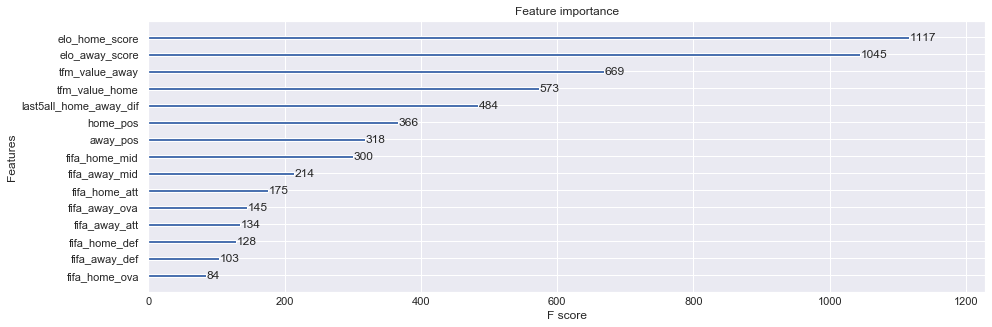

In [61]:
xgb.plot_importance(model)

C:\Users\Mark\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


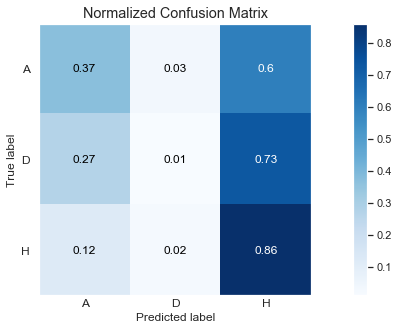

In [77]:
skplt.metrics.plot_confusion_matrix(
    y_test.apply(lambda x: transforma_final_result(x, True)),
    pd.Series(model.predict(xgb.DMatrix(x_test))).apply(lambda x: transforma_final_result(x, True)),
    normalize=True
)
plt.show()

Pela Confusion Matrix podemos visualizar alguns pontos fracos e fortes do modelo. O melhor resultado possível é quando a diagonal da esquerda para a direita e de cima para baixo é visível. Nessas 3 posições (AxA, DxD e HxH) o resultado original e o previsto são iguais.

Essa diagonal não está presente no modelo e olhando a matriz é possível ver que os resultados tiveram um viés para o time da casa (o lado direito está mais azul que o da esquerda). Os verdadeiros positivos da `classe H (home)` tiveram um bom desempenho: 86% dos dados foram previstos corretamente. Na `classe de empate (D)` a previsão falhou com bastante sobra já que previu de maneira errada 99% das vezes. Apenas 1% das vezes o modelo acertou o resultado do jogo. A `classe de resultados favoráveis ao visitante (A)` também não teve um desempenho satisfatório: apenas 37% dos dados foram corretamente previstos.

Apesar das técnicas que foram aplicadas para tentar melhorar o desempenho do modelo, nenhuma delas teve um resultado expressivo. Uma causa disso pode ter sido a mistura entre várias ligas da Europa. Talvez se fossem aplicados métodos semelhantes em apenas uma liga com dados de vários anos anteriores o resultado poderia ter sido melhor.
Um fato interessante é o score elo ser extremamente eficaz para fazer as previsões. Tanto no Random Forest quanto no XGBoost foram de longe as 2 features mais importantes para o modelo. Isso mostra que esse score pode representar de maneira eficiente qual o patamar atual do time.

Vários esportes usam o score elo ou alguma variação sua para fazer algum tipo de ranking. O Tênis é um esporte que pode ser bastante previsível pois geralmente um jogador com score mais alto que se adversário acaba ganhando. E se pensarmos bem, as finais quase sempre constam com os mesmos figuras: Djokovic, Nadal, Federer, del Potro, etc...

O futebol não é tão previsível e isso se traduz na análise que foi feita. Prever um resultado é muito mais que estatística e machine learning e o fator humano é o mais importante de todos. Devemos sempre pensar que o modelo preditivo é mais uma ferramenta de auxílio do que uma receita de bolo a ser seguida.